# SKC 2018.03.22 Dataset
=============
분석자: 정회희 (Last update: 2018/05/09)

## Problem definition, evaluation 및 데이터셋 관련 기본 정보

- 데이터셋 저장 경로: //211.106.187.119/Data/052_SKC/20180322/original
- 산업 도메인: 필름
- 문제 유형: Classification
- 클래스 유형: 11 Classes
    - 탄화물 : 2242
    - M line : 5736
    - 미연신 : 616
    - 종Scratch : 5094
    - 기포 : 2487
    - 조액 : 17875
    - 오일오염 : 1266
    - 백분 : 9426
    - 기타결함 : 38433
    - 흑색결함 : 1502
    - 횡Scratch : 2262
- 이미지 유형: Single-RGB-image
- 원본 이미지 크기 및 채널 수: 128 x 128 x 3
- Evaluation
    - Evaluation metric: Error rate
    - Evaluation method: 하나의 원본 이미지를 하나의 제품 인스턴스로 하여 성능 도출
    

In [1]:
import os, sys
sys.path.append('..')
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import json

from sklearn.manifold import TSNE
from skimage.io import imread, imsave

from datasets import skc as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from models.utils import grad_cam, get_feature_maps

from datasets.utils import view_image_cam_pairs

In [2]:
image_save_dir = './images'

In [3]:
""" Load dataset """
root_dir = ('/Data/skc/20180424/original')

In [4]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
cls_list = anno_dict['classes'].values()
print(cls_list)

dict_values(['횡Scratch', '조액', '기타결함', '오일오염', '탄화물', 'M line', '미연신', '종Scratch', '기포', '흑색결함', '백분'])


In [5]:
imset_path = os.path.join(root_dir, 'imageset','imageset1')

file_list = []
for txt in ['train1.txt','validation1.txt','test.txt']:
    with open(os.path.join(imset_path,txt)) as fid:
        tmp = fid.read().split('\n')[:-1]
        file_list += tmp

print('모든 데이터셋 크기:',len(file_list))

모든 데이터셋 크기: 86939


백분 : 9426
횡Scratch : 2262
탄화물 : 2242
기포 : 2487
흑색결함 : 1502
오일오염 : 1266
조액 : 17875
M line : 5736
미연신 : 616
종Scratch : 5094
기타결함 : 38433


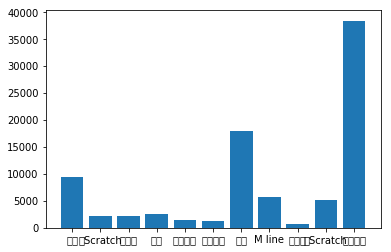

In [6]:
dic = {cls:[] for cls in cls_list}

for file in file_list:
    cls = file.split('_')[0]
    dic[cls].append(file)

y =[]
x = []
for cls in dic.keys():
    print(cls,':',len(dic[cls]))
    x.append(cls); y.append(len(dic[cls]))

plt.bar(range(len(x)),y, tick_label=x)
plt.show()
plt.savefig(os.path.join(image_save_dir,'class_bar.png'))

In [22]:
n_rows = len(dic.keys())
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

for j in range(n_rows):
    c = list(dic.keys())[j]
    samples = np.random.choice(dic[c], size=n_rows, replace=False)
    for i in range(n_cols):
        filename = samples[i]
        file_path = os.path.join(root_dir, 'image', filename)
        image = imread(file_path)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title(filename)

#plt.show()
plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')

---

## 초기 학습 및 테스트 방법

### Architecture
- ResNet-18

### Optimization, Regularization

#### Parameter initialization

- He et al.의 normal initialization 방법을 채택함
    - He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.
    
#### Gradient descent optimizer

- SGD + momentum

#### Training hyperparameters

- Batch size: 64
- Number of epochs: 100
- Initial learning rate: 0.05
- Momentum: 0.9
- Learning rate decay schedule: validation 성능이 plateau를 보일 때마다, 기존 learning rate를 decay 
    - learning rate patience = 10
    - validation score threshold: 1e-4
    - learning rate decay: 0.1
        - 위의 각 hyperparameters에 대한 설명의 경우, SuaLab 기술 블로그의 AlexNet 학습 부분 참조
- Batch sampling 방법: uniform sampling
        
#### Regularization

- L2 weight decay: 0.0001
- Data augmentation: LR flip, UD flip (4x augmentation)
    - Training 시에만 LR flip, UD flip, LR+UD flip 각각 25% 확률로 augmentation 수행
    - Test 시에는 augmentation을 수행하지 않음
- Batch normalization
    - 모든 conv layer와 ReLU layer 사이에 batch normalization을 적용

----
## 초기 분석 결과 및 체크리스트 관련 코멘트

In [8]:
# Load test set
test_list, anno_dict = dataset.read_skc_subset(root_dir, mode='test')
test_set = dataset.Dataset(root_dir, test_list, anno_dict)

In [9]:
""" Set test hyperparameters """
hp_d = dict()
mean = np.array([0.3711091, 0.3711091, 0.3711091], dtype=np.float32)
image_mean = np.transpose(np.tile(mean,(224,224,1)),[2,0,1])
hp_d['image_mean'] = image_mean

# Test hyperparameters
hp_d['batch_size'] = 256

In [10]:
""" Load weights and start test """
model = ConvNet([3, 224, 224], len(anno_dict['classes']), **hp_d)
model.logits.restore('/Data/checkpts/model_trainval1.dnn') # FIXME
evaluator = Evaluator()
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = model.predict(test_set, **hp_d)

total_time = time.time() - start_time

/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/cntk/core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


conv1.shape (64, 112, 112)
pool1.shape (64, 56, 56)
conv2_2.shape (64, 56, 56)
conv3_2.shape (128, 28, 28)
conv4_2.shape (256, 14, 14)
conv5_2.shape (512, 7, 7)
pool6.shape (512, 1, 1)


### Accuracy 측정 결과

In [11]:
print('Test error rate: {}'.format(test_score))

Test error rate: 0.08611376241201608


솔루션 개발팀에서 말하기로 정확도가 92% 가량 나왔다고 했는데, 91.4% 나왔음.
이는 어느정도 비슷한 값에 도달한 것이라고 파악됨. 

### Tact time 측정 결과

In [12]:
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))

Total tack time(sec): 22.40752077102661
Tact time per image(sec): 0.0012888255361225476


### Confusion matrix 결과

In [13]:
print('Confusion matrix: \n{}'.format(confusion_matrix))
print('Remind:')
for i in range(len(anno_dict['classes'])):
    print(i,anno_dict['classes'][str(i)])

Confusion matrix: 
[[ 382    1    0    1    0    0    0   52    0    0    0]
 [   0  133    1    4    4    1    0    7    0    0    0]
 [   0    0  279    0    0    0    0    2    0    0    0]
 [   1    2    0 3353    1    9    4  211    0    1   24]
 [   0    0    2    9  383    0    0   38    0    0    0]
 [   0    0    0   31    0 1115    0    9    4    0    9]
 [   1    0    0    1    1    0  218   22    0    0    1]
 [  43    2    0  190   28   12    9 7203   36    8  149]
 [   0    0    0    5    0   12    0   76  829    0   83]
 [   0    0    0    1    2    0    0   34    0  470    0]
 [   0    0    0   76    3   13    1  165   95    0 1524]]
Remind:
0 횡Scratch
1 미연신
2 흑색결함
3 조액
4 탄화물
5 M line
6 오일오염
7 기타결함
8 종Scratch
9 기포
10 백분


In [21]:
temp = ''
temp += '| |'
for i in range(len(confusion_matrix[0])):
    temp += 'y^={}|'.format(i)
temp += '\n'
temp += '|-----|'
for i in range(len(confusion_matrix[0])):
    temp += '-----|'.format(i)
temp += '\n'
ct = 0
for row in confusion_matrix:
    temp += '|y={}|'.format(ct)
    for ele in row:
        temp += '{}|'.format(ele)
    temp += '\n'
    ct += 1
print(temp)

| |y^=0|y^=1|y^=2|y^=3|y^=4|y^=5|y^=6|y^=7|y^=8|y^=9|y^=10|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|y=0|382|1|0|1|0|0|0|52|0|0|0|
|y=1|0|133|1|4|4|1|0|7|0|0|0|
|y=2|0|0|279|0|0|0|0|2|0|0|0|
|y=3|1|2|0|3353|1|9|4|211|0|1|24|
|y=4|0|0|2|9|383|0|0|38|0|0|0|
|y=5|0|0|0|31|0|1115|0|9|4|0|9|
|y=6|1|0|0|1|1|0|218|22|0|0|1|
|y=7|43|2|0|190|28|12|9|7203|36|8|149|
|y=8|0|0|0|5|0|12|0|76|829|0|83|
|y=9|0|0|0|1|2|0|0|34|0|470|0|
|y=10|0|0|0|76|3|13|1|165|95|0|1524|



row: $y=i$

column: $\hat{y}=j$

를 의미함. diagonal element가 대체로 큰 것을 확인할 수 있음.

그리고 기타결함이 다양하고, 많은 데이터를 갖고 있기 때문에, 기타결함을 위주로 에러가 많이 발생한 것을 확인할 수 있음.

### Performance - training set size plot

In [14]:
import os
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Load results from pickle file
with open('../output/cv_skc_resnet_test_result.pkl', 'rb') as fid:
    test_result_dict = pkl.load(fid)

In [15]:
test_score_per_train_portion = dict()
for fold_idx in test_result_dict.keys():
    for portion in test_result_dict[fold_idx].keys():
        if portion not in test_score_per_train_portion:
            test_score_per_train_portion[portion] = []
        test_score_per_train_portion[portion].append(test_result_dict[fold_idx][portion])
# test_score_per_train_portion
# >> {1.0: [result1 by fold1, result2 by fold2, ...], 0.75: [resutl1 by fold1, ...], ...}

<Figure size 432x288 with 0 Axes>

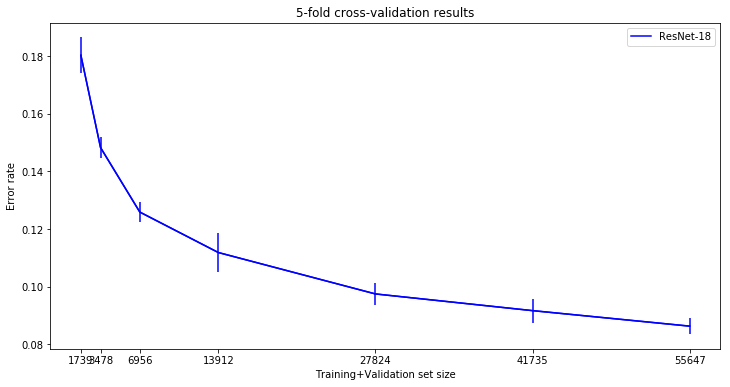

In [16]:
trainval_list, _ = dataset.read_skc_subset(root_dir, mode='train1')
total_set_size = len(trainval_list)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = [v*total_set_size for v in sorted(test_score_per_train_portion.keys())]
y_mean = [np.mean(l) for k, l in sorted(test_score_per_train_portion.items())]
y_std = [np.std(l) for k, l in sorted(test_score_per_train_portion.items())]
_ = ax.plot(x, y_mean, color='b', label='ResNet-18')
_ = ax.errorbar(x, y_mean, yerr=y_std, color='b')
_ = ax.set_title('5-fold cross-validation results')
_ = ax.set_ylabel('Error rate')
_ = ax.set_xlabel('Training+Validation set size')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.show()
plt.savefig(os.path.join(image_save_dir, 'cross_validation_results.png'), bbox_inches='tight')

# >> output: accuracy graph averaged over 5 folds

데이터셋의 크기가 늘어날 수록 정확도가 상승함을 확인할 수 있음.
데이터셋의 크기가 0.5 이하로 떨어질 경우에 정확도가 급격히 낮아짐을 확인함.
0.5를 기준으로 1.0을 관측했을 때 데이터셋 크기가 2배 가량 증가했음에도 눈에 띄게 큰 향상은 없었음.

### CAM visualization on the feature layer


Correct ones for class 횡Scratch


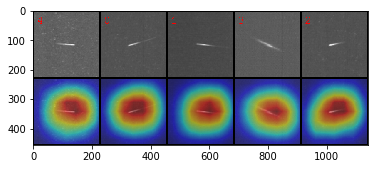

Wrong ones for class 횡Scratch


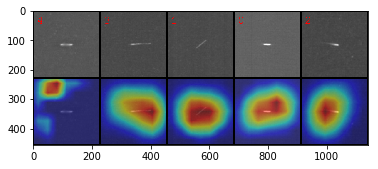

Correct ones for class 미연신


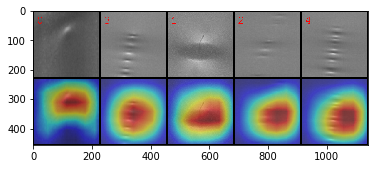

Wrong ones for class 미연신


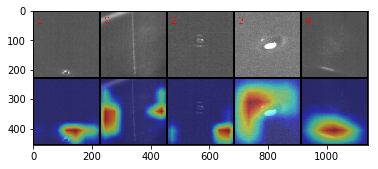

Correct ones for class 흑색결함


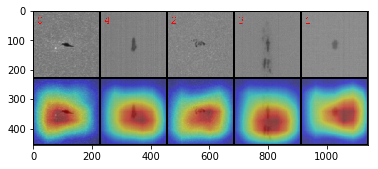

Wrong ones for class 흑색결함


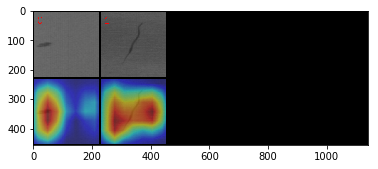

Correct ones for class 조액


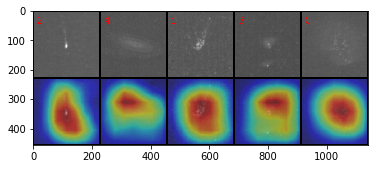

Wrong ones for class 조액


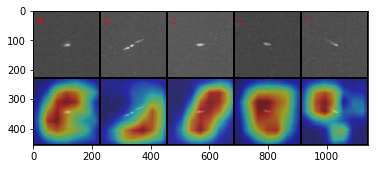

Correct ones for class 탄화물


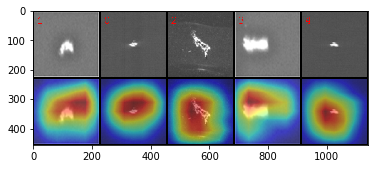

Wrong ones for class 탄화물


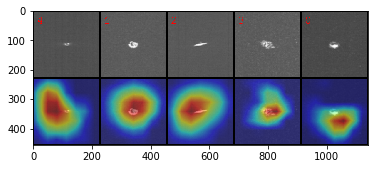

Correct ones for class M line


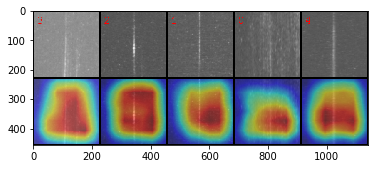

Wrong ones for class M line


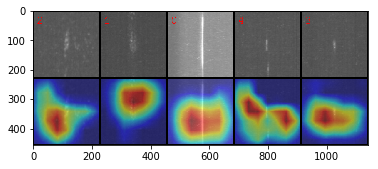

Correct ones for class 오일오염


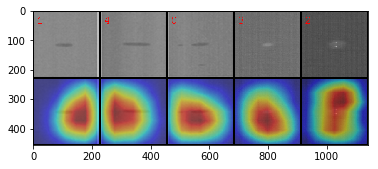

Wrong ones for class 오일오염


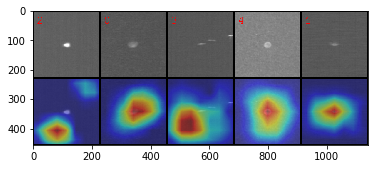

Correct ones for class 기타결함


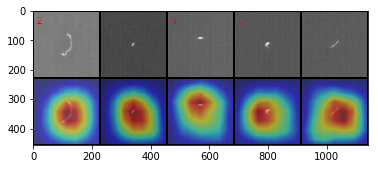

Wrong ones for class 기타결함


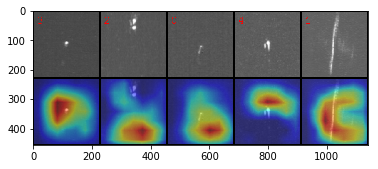

Correct ones for class 종Scratch


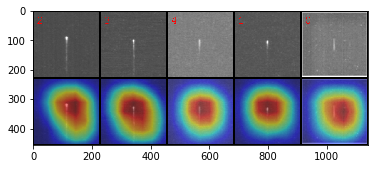

Wrong ones for class 종Scratch


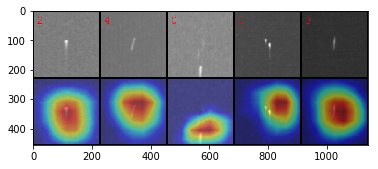

Correct ones for class 기포


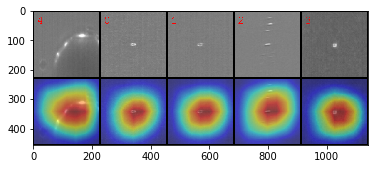

Wrong ones for class 기포


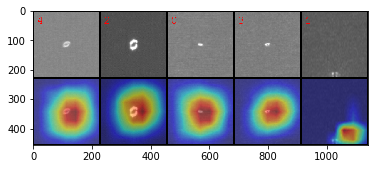

Correct ones for class 백분


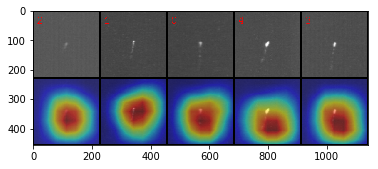

Wrong ones for class 백분


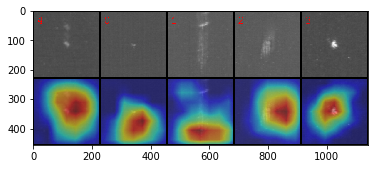

In [17]:
num_samples = 5 # FIXME

test_list_cor = []
test_list_wrn = []

for i in range(ys.shape[1]):
    correct = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)==i))
    wrong = np.logical_and((ys.argmax(axis=1)==i),(y_preds.argmax(axis=1)!=i))
    test_list_cor.append(np.extract(correct, test_list))
    test_list_wrn.append(np.extract(wrong, test_list))
    
#print(len(test_list_cor))
#print(len(test_list_wrn))

test_list_cam = [test_list_cor, test_list_wrn]

for i in range(len(test_list_cor)):
    for j in range(2):
        corwrn = 'Correct' * (1-j) + 'Wrong' * j
        print('{} ones for class {}'.format(corwrn,anno_dict['classes'][str(i)]))
        try:
            filename_list = test_list_cam[j][i][0:num_samples]
            cam, X = grad_cam(model, dataset, root_dir, filename_list, anno_dict, i, 'conv5_2', **hp_d)
            img = view_image_cam_pairs(X, cam, n_samples=num_samples, border=2, n_cols=num_samples)
            imshow(img)
            plt.show()
            imsave(os.path.join(image_save_dir, 'class_{}_{}_grad_cam.jpg'.format(i,corwrn)), img)
        except:
            print('Not enough data for {} ones'.format(corwrn))


11개의 class에 대해서 정답인 경우와 오답인 경우에 대해서 GradCAM을 찍어보았음.

틀리던 맞던 대부분 유의해야 할 점을 잘 찾아서 분류를 함.

GradCAM이 망가지는 경우는 큰 패턴이 들어왔을 경우임.
예를 들어서 미연신의 경우, 정답을 맞췄을 경우에는 정확한 위치를 찾지만 오답의 경우에는 대부분 무너짐.
M line의 경우도 보통 사람 같으면 선을 찾아내야 할 것 같은데 그렇지 않음. 정답의 경우에는 전반적인 내용을 보고, 오답의 경우에는 국소 부위만 본다는 결과가 나옴.

하지만 대부분의 에러는 사람도 헷깔릴 법하게 생긴 것이 많음. 
(예를 들어서 M line인데 선이 아니라 그냥 점인 경우, 백분인데 점이 아니라 선인 경우 등)

따라서 어느정도 잘 학습이 되었다고 할 수 있음.

### T-SNE visualization on the feature layer

In [19]:
test_feature_maps, images, test_labels = get_feature_maps(model, dataset, root_dir, test_list, anno_dict, 'conv5_2', **hp_d)
print(test_feature_maps.shape)

ValueError: axes don't match array

In [ ]:
# Flatten feature maps into feature vectors
test_features = test_feature_maps.reshape((test_feature_maps.shape[0], -1))
print(test_features.shape)

In [ ]:
#import time
#tic = time.time()
#test_embeddings = TSNE(n_components=2, verbose=1).fit_transform(test_features)
#toc = time.time()
#print('TSNE takes {} secs'.format(toc-tic))
#print(test_embeddings.shape)
#np.save('./test_embeddings.npy',test_embeddings)
test_embeddings = np.load('./test_embeddings.npy')

# if it takes too much time, reduce data into half, or etc.

In [ ]:
from datasets.utils import view_tsne_embeddings

In [ ]:
#images = np.ones((17386,3,28,28)) # (N,C,H,W)
emb_image = view_tsne_embeddings(test_embeddings, images, test_labels)
imsave(os.path.join(image_save_dir, 'convnet_embed.jpg'), emb_image)

In [ ]:
from skimage.transform import resize
img = images[0]
img = np.transpose(img, [1,2,0])
im = resize(img,(28,28),mode='constant')
im.shape
imshow(im)
plt.show()